In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models  

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm, trange
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import confusion_matrix, accuracy_score  
import seaborn as sns


In [19]:
class Config:
    data_dir = "D:\\Leko\\medical_model\\task1\\dataset\\images"
    label_csv = "D:\\Leko\\medical_model\\task1\\dataset\\labels.csv"
    img_size = 224
    batch_size = 32
    epochs = 20
    lr = 5e-4  # ✅ ResNet34 推荐使用略高的学习率（如 5e-4 或 1e-4）
    num_workers = 0  # ✅ 增加 num_workers 提升加载速度
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_name = "resnet34"  # ✅ 替换为 ResNet34
    save_dir = "./output"
    seed = 42

torch.manual_seed(Config.seed)
os.makedirs(Config.save_dir, exist_ok=True)

In [20]:
class TumorDataset(Dataset):
    def __init__(self, df, img_dir, train=True):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.train = train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = np.array(Image.open(img_path).convert('RGB'))
        label = int(row['label'])

        # ✅ 根据训练 or 验证阶段选择 transform
        if self.train:
            transform = get_transforms(train=True, is_tumor=(label == 1))
        else:
            transform = get_transforms(train=False)

        image = transform(image=image)['image']
        return image, label


In [21]:
class CutMixCollator:
    def __init__(self, beta=1.0, prob=0.5):
        self.beta = beta
        self.prob = prob

    def __call__(self, batch):
        images, labels = zip(*batch)
        images = torch.stack(images)
        labels = torch.tensor(labels).float().view(-1, 1)  # ✅ 修复维度问题

        if np.random.rand() > self.prob:
            return images, labels

        lam = np.random.beta(self.beta, self.beta)
        batch_size = images.size(0)
        index = torch.randperm(batch_size)

        mixed_images = lam * images + (1 - lam) * images[index]
        mixed_labels = lam * labels + (1 - lam) * labels[index]
        return mixed_images, mixed_labels



class MixUpCollator:
    def __init__(self, alpha=0.4, prob=0.5):
        self.alpha = alpha
        self.prob = prob

    def __call__(self, batch):
        images, labels = zip(*batch)
        images = torch.stack(images)
        labels = torch.tensor(labels).float().view(-1, 1)


        if np.random.rand() > self.prob:
            return images, labels

        lam = np.random.beta(self.alpha, self.alpha)
        index = torch.randperm(images.size(0))
        mixed_images = lam * images + (1 - lam) * images[index]
        labels = lam * labels + (1 - lam) * labels[index]
        return mixed_images, labels


In [22]:
def get_transforms(train=True, is_tumor=False):
    if train:
        base = [
            A.Resize(Config.img_size, Config.img_size),
            A.HorizontalFlip(p=0.5),
        ]
        if is_tumor:
            base += [
                A.RandomBrightnessContrast(p=0.5),
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
                A.CoarseDropout(p=0.3)
            ]
        base += [
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ]
        return A.Compose(base)
    else:
        return A.Compose([
            A.Resize(Config.img_size, Config.img_size),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])


In [23]:
class TumorClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # 1) 加载预训练 ResNet34，去掉原来的 fc
        backbone = models.resnet34(pretrained=True)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()

        self.backbone = backbone
        # 2) 基础分类头：一层 Linear，输出 (B,1)
        self.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        # backbone 输出 [B, 512]
        features = self.backbone(x)
        # classifier 输出 [B, 1]
        out = self.classifier(features)
        return out


In [24]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()


In [25]:
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    total_loss = 0
    for images, labels in tqdm(loader):
        images = images.to(Config.device)
        labels = labels.float().unsqueeze(1).to(Config.device)  # [B,1]
        
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)        # [B,1]
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

In [26]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(Config.device)
            labels = labels.float().unsqueeze(1).to(Config.device)  # 已正确处理

            with autocast():
                outputs = model(images)    # [B,1]
                loss = criterion(outputs, labels)

            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds.extend(probs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return total_loss / len(loader), np.array(preds), np.array(targets)

In [27]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

In [28]:
from sklearn.model_selection import train_test_split

# 读取 CSV 标签
full_df = pd.read_csv(Config.label_csv)

# 三分法划分 train / val / test
train_df, tmp_df = train_test_split(
    full_df,
    test_size=0.3,
    stratify=full_df['label'],
    random_state=Config.seed
)
val_df, test_df = train_test_split(
    tmp_df,
    test_size=0.5,
    stratify=tmp_df['label'],
    random_state=Config.seed
)

print(f"训练集类别分布：\n{train_df['label'].value_counts()}")
print(f"验证集类别分布：\n{val_df['label'].value_counts()}")
print(f"测试集类别分布：\n{test_df['label'].value_counts()}")

# 设置增强策略：baseline 不使用 CutMix/MixUp
use_mix_mode = "none"
collate_fn = None

# Baseline 下直接随机打乱，不使用加权采样
sampler = None

# 构建 Dataset 和 DataLoader
train_dataset = TumorDataset(train_df, Config.data_dir, train=True)
val_dataset   = TumorDataset(val_df,   Config.data_dir, train=False)
test_dataset  = TumorDataset(test_df,  Config.data_dir, train=False)

train_loader = DataLoader(
    train_dataset,
    batch_size=Config.batch_size,
    shuffle=True,
    num_workers=Config.num_workers,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=Config.batch_size,
    shuffle=False,
    num_workers=Config.num_workers
)
test_loader = DataLoader(
    test_dataset,
    batch_size=Config.batch_size,
    shuffle=False,
    num_workers=Config.num_workers
)

# 初始化模型
print("🧠 初始化模型中...")
model = TumorClassifier().to(Config.device)
print("✅ 模型初始化完成")

optimizer = optim.Adam(
    model.parameters(),
    lr=Config.lr,
    weight_decay=1e-4
)
criterion = nn.BCEWithLogitsLoss()
early_stopper = EarlyStopping(patience=5)
scaler = GradScaler()

history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_f1': []}
best_auc = 0
best_thresh = 0.5  # 会在训练中更新

# 显示训练集类别分布
train_labels = train_df['label']
print(f"📊 当前训练集图像分布：正常类 {(train_labels == 0).sum()}，肿瘤类 {(train_labels == 1).sum()}")

训练集类别分布：
label
0    7552
1    1816
Name: count, dtype: int64
验证集类别分布：
label
0    1618
1     389
Name: count, dtype: int64
测试集类别分布：
label
0    1619
1     389
Name: count, dtype: int64
🧠 初始化模型中...


c:\Users\15307\.conda\envs\multi_task\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\15307\.conda\envs\multi_task\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ 模型初始化完成
📊 当前训练集图像分布：正常类 7552，肿瘤类 1816


C:\Users\15307\AppData\Local\Temp\ipykernel_19212\932918833.py:68: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


训练集类别分布：
label
0    7552
1    1816
Name: count, dtype: int64
验证集类别分布：
label
0    1618
1     389
Name: count, dtype: int64
测试集类别分布：
label
0    1619
1     389
Name: count, dtype: int64
🧠 初始化模型中...


c:\Users\15307\.conda\envs\multi_task\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\15307\.conda\envs\multi_task\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2487494795.py:68: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


✅ 模型初始化完成
📊 当前训练集图像分布：正常类 7552，肿瘤类 1816

📘 Epoch 1/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [03:52<00:00,  1.26it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.3006 | Val Loss: 0.4215 | AUC: 0.8578
F1@0.50: 0.3038 | ✅ Best F1@0.14: 0.5981
🎯 Accuracy: 0.8540
🧪 Sensitivity (Recall for tumor): 0.5604
🧪 Specificity (Recall for normal): 0.9246
✅ Best model saved.

📘 Epoch 2/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:42<00:00,  2.87it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.2362 | Val Loss: 0.3696 | AUC: 0.8960
F1@0.50: 0.6674 | ✅ Best F1@0.70: 0.6912
🎯 Accuracy: 0.8829
🧪 Sensitivity (Recall for tumor): 0.6761
🧪 Specificity (Recall for normal): 0.9326
✅ Best model saved.

📘 Epoch 3/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:42<00:00,  2.87it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.2113 | Val Loss: 0.5630 | AUC: 0.7943
F1@0.50: 0.3049 | ✅ Best F1@0.12: 0.4979
🎯 Accuracy: 0.7608
🧪 Sensitivity (Recall for tumor): 0.6118
🧪 Specificity (Recall for normal): 0.7967

📘 Epoch 4/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:41<00:00,  2.88it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1938 | Val Loss: 0.3295 | AUC: 0.9004
F1@0.50: 0.4765 | ✅ Best F1@0.14: 0.6823
🎯 Accuracy: 0.8714
🧪 Sensitivity (Recall for tumor): 0.7121
🧪 Specificity (Recall for normal): 0.9098
✅ Best model saved.

📘 Epoch 5/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:42<00:00,  2.87it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1826 | Val Loss: 0.3113 | AUC: 0.9102
F1@0.50: 0.6422 | ✅ Best F1@0.28: 0.7300
🎯 Accuracy: 0.9008
🧪 Sensitivity (Recall for tumor): 0.6915
🧪 Specificity (Recall for normal): 0.9512
✅ Best model saved.

📘 Epoch 6/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:42<00:00,  2.86it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1725 | Val Loss: 0.3993 | AUC: 0.8804
F1@0.50: 0.2895 | ✅ Best F1@0.12: 0.6728
🎯 Accuracy: 0.8749
🧪 Sensitivity (Recall for tumor): 0.6632
🧪 Specificity (Recall for normal): 0.9258

📘 Epoch 7/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:42<00:00,  2.87it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1671 | Val Loss: 0.3744 | AUC: 0.8833
F1@0.50: 0.5496 | ✅ Best F1@0.12: 0.6781
🎯 Accuracy: 0.8784
🧪 Sensitivity (Recall for tumor): 0.6607
🧪 Specificity (Recall for normal): 0.9308

📘 Epoch 8/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:41<00:00,  2.88it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1546 | Val Loss: 0.4362 | AUC: 0.8676
F1@0.50: 0.6122 | ✅ Best F1@0.36: 0.6280
🎯 Accuracy: 0.8371
🧪 Sensitivity (Recall for tumor): 0.7095
🧪 Specificity (Recall for normal): 0.8677

📘 Epoch 9/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:42<00:00,  2.87it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1593 | Val Loss: 0.3186 | AUC: 0.8928
F1@0.50: 0.5503 | ✅ Best F1@0.22: 0.6454
🎯 Accuracy: 0.8560
🧪 Sensitivity (Recall for tumor): 0.6761
🧪 Specificity (Recall for normal): 0.8993

📘 Epoch 10/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:42<00:00,  2.85it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1498 | Val Loss: 0.3428 | AUC: 0.9182
F1@0.50: 0.5874 | ✅ Best F1@0.10: 0.7143
🎯 Accuracy: 0.8864
🧪 Sensitivity (Recall for tumor): 0.7326
🧪 Specificity (Recall for normal): 0.9234
✅ Best model saved.

📘 Epoch 11/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:42<00:00,  2.86it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1438 | Val Loss: 0.2812 | AUC: 0.9193
F1@0.50: 0.6809 | ✅ Best F1@0.25: 0.7339
🎯 Accuracy: 0.8974
🧪 Sensitivity (Recall for tumor): 0.7301
🧪 Specificity (Recall for normal): 0.9376
✅ Best model saved.

📘 Epoch 12/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:42<00:00,  2.85it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1296 | Val Loss: 0.3128 | AUC: 0.8962
F1@0.50: 0.6210 | ✅ Best F1@0.30: 0.6781
🎯 Accuracy: 0.8784
🧪 Sensitivity (Recall for tumor): 0.6607
🧪 Specificity (Recall for normal): 0.9308

📘 Epoch 13/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:42<00:00,  2.86it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1429 | Val Loss: 0.2999 | AUC: 0.9189
F1@0.50: 0.6264 | ✅ Best F1@0.15: 0.7314
🎯 Accuracy: 0.8884
🧪 Sensitivity (Recall for tumor): 0.7841
🧪 Specificity (Recall for normal): 0.9135

📘 Epoch 14/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:43<00:00,  2.84it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1303 | Val Loss: 0.3395 | AUC: 0.9308
F1@0.50: 0.6061 | ✅ Best F1@0.10: 0.7408
🎯 Accuracy: 0.9013
🧪 Sensitivity (Recall for tumor): 0.7275
🧪 Specificity (Recall for normal): 0.9431
✅ Best model saved.

📘 Epoch 15/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:42<00:00,  2.85it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1225 | Val Loss: 0.3005 | AUC: 0.9121
F1@0.50: 0.6026 | ✅ Best F1@0.20: 0.7134
🎯 Accuracy: 0.8899
🧪 Sensitivity (Recall for tumor): 0.7069
🧪 Specificity (Recall for normal): 0.9339

📘 Epoch 16/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:42<00:00,  2.85it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1259 | Val Loss: 0.3082 | AUC: 0.9055
F1@0.50: 0.6373 | ✅ Best F1@0.36: 0.6750
🎯 Accuracy: 0.8829
🧪 Sensitivity (Recall for tumor): 0.6272
🧪 Specificity (Recall for normal): 0.9444

📘 Epoch 17/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:42<00:00,  2.86it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1199 | Val Loss: 0.2847 | AUC: 0.9161
F1@0.50: 0.6979 | ✅ Best F1@0.42: 0.7135
🎯 Accuracy: 0.8904
🧪 Sensitivity (Recall for tumor): 0.7044
🧪 Specificity (Recall for normal): 0.9351

📘 Epoch 18/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:42<00:00,  2.85it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1201 | Val Loss: 0.3110 | AUC: 0.9120
F1@0.50: 0.6232 | ✅ Best F1@0.15: 0.7066
🎯 Accuracy: 0.8829
🧪 Sensitivity (Recall for tumor): 0.7275
🧪 Specificity (Recall for normal): 0.9203

📘 Epoch 19/20


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:42<00:00,  2.85it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1147 | Val Loss: 0.3772 | AUC: 0.8954
F1@0.50: 0.5890 | ✅ Best F1@0.17: 0.6765
🎯 Accuracy: 0.8794
🧪 Sensitivity (Recall for tumor): 0.6504
🧪 Specificity (Recall for normal): 0.9345
⏹️ Early stopping triggered.


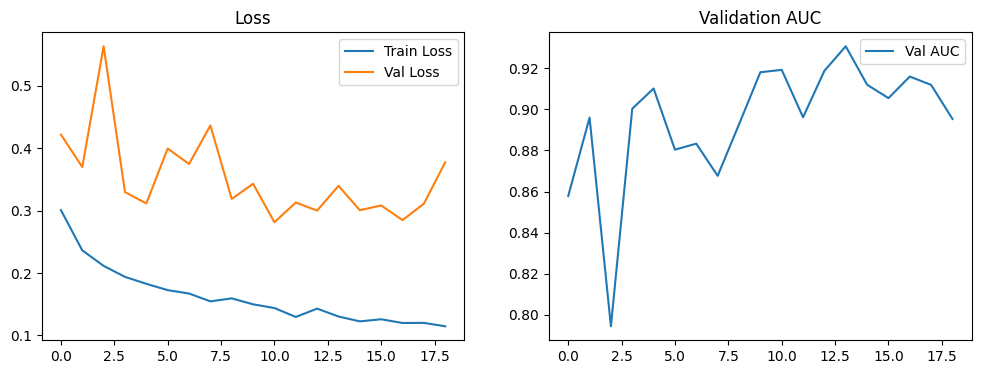

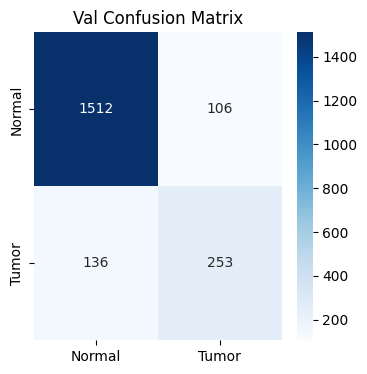


🚀 Evaluating on Test Set...


C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🧪 Test Loss: 0.3534 | Test AUC: 0.9210 | Test F1: 0.7090 | Test Acc: 0.8974


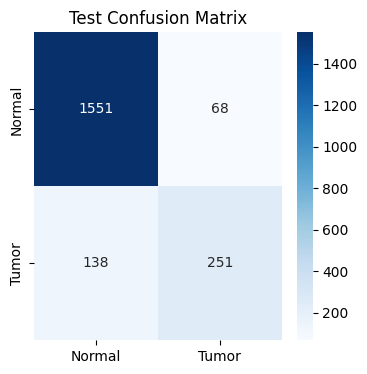

In [ ]:
for epoch in range(Config.epochs):
    print(f"\n📘 Epoch {epoch+1}/{Config.epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    val_loss, preds, targets = evaluate(model, val_loader, criterion)
    val_auc = roc_auc_score(targets, preds)

    # 最佳 F1 阈值搜索
    val_f1_default = f1_score(targets, (preds >= 0.5).astype(int))
    curr_best_f1, curr_best_thresh = 0, 0.5
    for t in np.arange(0.1, 0.9, 0.01):
        f1 = f1_score(targets, (preds >= t).astype(int))
        if f1 > curr_best_f1:
            curr_best_f1, curr_best_thresh = f1, t
    best_thresh = curr_best_thresh
    preds_bin = (preds >= best_thresh).astype(int)

    # 打印指标
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | AUC: {val_auc:.4f}")
    print(f"F1@0.50: {val_f1_default:.4f} | ✅ Best F1@{best_thresh:.2f}: {curr_best_f1:.4f}")
    print(f"🎯 Accuracy: {accuracy_score(targets, preds_bin):.4f}")

    tn, fp, fn, tp = confusion_matrix(targets, preds_bin).ravel()
    print(f"🧪 Sensitivity (Recall for tumor): {tp/(tp+fn+1e-8):.4f}")
    print(f"🧪 Specificity (Recall for normal): {tn/(tn+fp+1e-8):.4f}")

    # 记录历史
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    history['val_f1'].append(curr_best_f1)

    # 保存最优模型
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), os.path.join(Config.save_dir, "best_model.pth"))
        with open(os.path.join(Config.save_dir, "best_thresh.txt"), 'w') as f:
            f.write(f"{best_thresh:.2f}")
        print("✅ Best model saved.")

    # 早停检查
    early_stopper(val_auc)
    if early_stopper.early_stop:
        print("⏹️ Early stopping triggered.")
        break

# 🎨 可视化训练历史
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'],   label='Val Loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_auc'], label='Val AUC')
plt.title("Validation AUC")
plt.legend()
plt.show()

# 🔥 混淆矩阵（最后一个 epoch 的验证集）
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(targets, preds_bin), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal","Tumor"], yticklabels=["Normal","Tumor"])
plt.title("Val Confusion Matrix")
plt.show()

# 保存验证集预测
val_df = val_df.copy()
val_df['pred_prob']  = preds
val_df['pred_label'] = preds_bin
val_df.to_csv(os.path.join(Config.save_dir, "val_predictions.csv"), index=False)


C:\Users\15307\AppData\Local\Temp\ipykernel_19212\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🧪 Test Loss: 0.3534 | Test AUC: 0.9210 | Test F1: 0.6138 | Test Acc: 0.8860
🧪 Test Sensitivity (Recall for tumor): 0.4679 | Test Specificity (Recall for normal): 0.9864


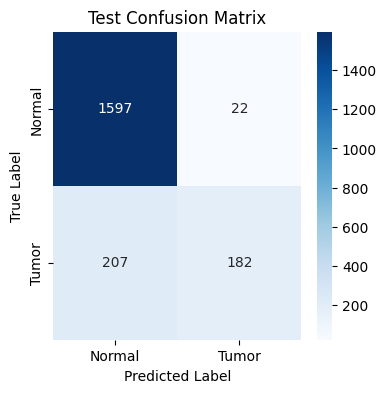

In [29]:
# 加载最佳模型
model.load_state_dict(torch.load(os.path.join(Config.save_dir, "best_model.pth")))
model.eval()

# 在测试集上评估
test_loss, test_preds, test_targets = evaluate(model, test_loader, criterion)
test_auc  = roc_auc_score(test_targets, test_preds)
test_f1   = f1_score(test_targets, (test_preds >= best_thresh).astype(int))
test_acc  = accuracy_score(test_targets, (test_preds >= best_thresh).astype(int))

# 计算混淆矩阵并提取指标
cm = confusion_matrix(test_targets, (test_preds >= best_thresh).astype(int))
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn + 1e-8)  # True Positive Rate
specificity = tn / (tn + fp + 1e-8)  # True Negative Rate

# 打印所有指标
print(f"🧪 Test Loss: {test_loss:.4f} | Test AUC: {test_auc:.4f} | "
      f"Test F1: {test_f1:.4f} | Test Acc: {test_acc:.4f}")
print(f"🧪 Test Sensitivity (Recall for tumor): {sensitivity:.4f} | "
      f"Test Specificity (Recall for normal): {specificity:.4f}")

# 绘制测试集混淆矩阵
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Tumor"],
            yticklabels=["Normal", "Tumor"])
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 保存测试集预测结果
test_df = test_df.copy()
test_df['pred_prob']  = test_preds
test_df['pred_label'] = (test_preds >= best_thresh).astype(int)
test_df.to_csv(os.path.join(Config.save_dir, "test_predictions.csv"), index=False)


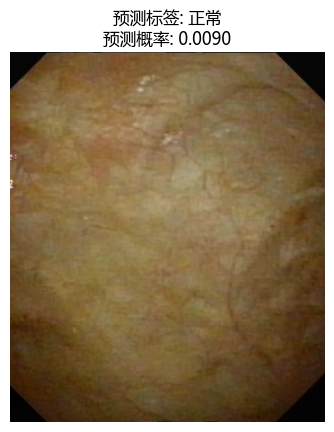

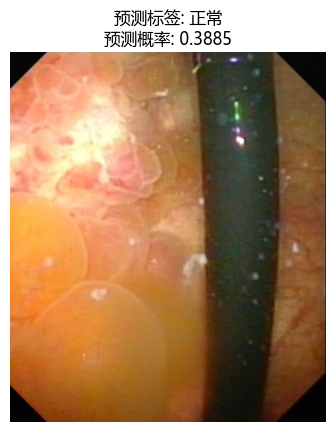

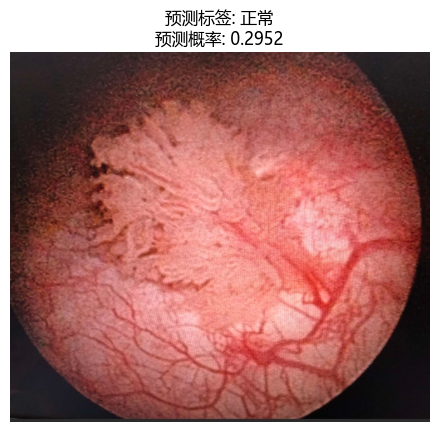

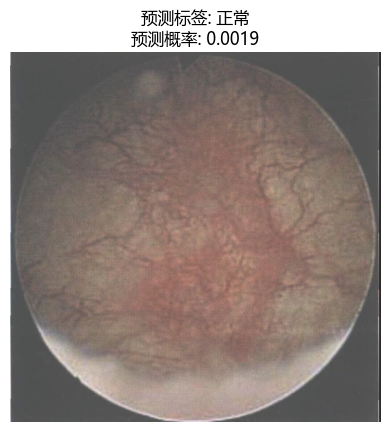

In [15]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import matplotlib

# ✅ 设置中文字体（以微软雅黑为例）
matplotlib.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# ✅ 加载模型结构（必须与你训练时的结构一致）
#model = TumorClassifier().to(Config.device)
model.load_state_dict(torch.load("D:\\Leko\\medical_model\\task1\\output\\best_model.pth"))
model.eval()

# ✅ 加载你训练时的图像预处理（transform）
infer_transform = get_transforms(train=False)

# ✅ 推理函数
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    
    # Apply transform
    transformed = infer_transform(image=image_np)
    input_tensor = transformed['image'].unsqueeze(0).to(Config.device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.sigmoid(output).item()
        label = 1 if prob >= 0.5 else 0

    # 可视化
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f"预测标签: {'肿瘤' if label==1 else '正常'}\n预测概率: {prob:.4f}")
    plt.show()

# ✅ 使用示例
predict_image("D:\\Leko\\test1.jpg")
predict_image("D:\\Leko\\test2.jpg")
predict_image("D:\\Leko\\test3.jpg")
predict_image("D:\\Leko\\test4.jpg")



In [33]:
# %% [markdown]
# ## 外部验证（External Validation）— 加载 best_model.pth，并输出指标

# %%
import os
import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import time

# 1. 配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# —— 修改点 1：把下面这个路径改成你的实际路径 —— 
ext_root = r'D:\Leko\testset\testset1(8)'  # ← 改这里！
best_model_path = r'D:\Leko\medical_model\task1\model\resnet34baseline\output\best_model.pth'

batch_size = 64
num_workers = 0

# 2. 预处理（要和训练时保持一致）
ext_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

# 3. 构建 ImageFolder + DataLoader
ext_dataset = ImageFolder(root=ext_root, transform=ext_transform)
print("Classes found:", ext_dataset.classes)  # 确认只有 ['normal','tumor']
ext_loader = DataLoader(
    ext_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)
print(f"External set: {len(ext_dataset)} images, {len(ext_loader)} batches")

model = TumorClassifier()
model.to(device)

ckpt = torch.load(best_model_path, map_location=device)
state_dict = ckpt.get('state_dict', ckpt)  # 如果你 save 时包了一层 dict
model.load_state_dict(state_dict)
model.eval()
print("✅ Loaded weights from", best_model_path)

# 5. 推理并收集结果
all_probs, all_labels = [], []
start = time.time()
with torch.inference_mode():
    for imgs, labels in tqdm(ext_loader, desc="Inference"):
        imgs = imgs.to(device, non_blocking=True)
        logits = model(imgs).view(-1)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.numpy())
print(f"Inference done in {(time.time()-start):.1f}s\n")

all_probs  = np.array(all_probs)
all_labels = np.array(all_labels).astype(int)

# 6. 计算指标 —— 修改点 2：加上 average='binary' —— 
preds = (all_probs >= 0.5).astype(int)
acc  = accuracy_score(all_labels, preds)
f1   = f1_score(all_labels, preds, average='binary')   # ← 改这里！
auc  = roc_auc_score(all_labels, all_probs)
tn, fp, fn, tp = confusion_matrix(all_labels, preds).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

# —— 修改点 3：把这个空的 print 换成真正输出 —— 
print("=== 外部验证结果 ===")
print(f"样本总数: {len(ext_dataset)} "
      f"(normal={ext_dataset.targets.count(0)}, tumor={ext_dataset.targets.count(1)})")
print(f"ACC:         {acc:.4f}")
print(f"F1-score:    {f1:.4f}")
print(f"AUC:         {auc:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")


Using device: cuda
Classes found: ['normal', 'tumor']
External set: 16006 images, 251 batches


c:\Users\15307\.conda\envs\multi_task\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\15307\.conda\envs\multi_task\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Loaded weights from D:\Leko\medical_model\task1\model\resnet34baseline\output\best_model.pth


Inference: 100%|██████████| 251/251 [08:31<00:00,  2.04s/it]

Inference done in 511.4s

=== 外部验证结果 ===
样本总数: 16006 (normal=14801, tumor=1205)
ACC:         0.1317
F1-score:    0.1464
AUC:         0.6249
Specificity: 0.0619
Sensitivity: 0.9892
